<a href="https://colab.research.google.com/github/hadif1999/iot_smoke_detection_ML/blob/main/smoke_detection_iot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#smoke_detection_iot project

###importing libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow.keras as tfk
import os

## preprocessing part

###reading data

### Downloading the dataset from GitHub

To download the dataset from GitHub, you'll need the raw URL of the CSV file. You can usually find this by navigating to the file on GitHub, clicking on the 'Raw' button, and then copying the URL from your browser's address bar.

Replace the placeholder URL below with the actual raw URL of your `smoke_detection_iot.csv` file.

In [7]:
import requests

# Replace with the actual raw GitHub URL of your CSV file
github_csv_url = "https://raw.githubusercontent.com/hadif1999/iot_smoke_detection_ML/main/smoke_detection_iot.csv"

response = requests.get(github_csv_url)
response.raise_for_status()  # Raise an HTTPError for bad responses (4xx or 5xx)

with open("smoke_detection_iot.csv", "wb") as f:
    f.write(response.content)

print("Dataset downloaded successfully to smoke_detection_iot.csv")

Dataset downloaded successfully to smoke_detection_iot.csv


In [8]:

data = pd.read_csv("smoke_detection_iot.csv")
data

,Unnamed: 0,UTC,Temperature[C],Humidity[%],TVOC[ppb],eCO2[ppm],Raw H2,Raw Ethanol,Pressure[hPa],PM1.0,PM2.5,NC0.5,NC1.0,NC2.5,CNT,Fire Alarm
0,0,1654733331,20.000,57.36,0,400,12306,18520,939.735,0.00,0.00,0.00,0.000,0.000,0,0
1,1,1654733332,20.015,56.67,0,400,12345,18651,939.744,0.00,0.00,0.00,0.000,0.000,1,0
2,2,1654733333,20.029,55.96,0,400,12374,18764,939.738,0.00,0.00,0.00,0.000,0.000,2,0
3,3,1654733334,20.044,55.28,0,400,12390,18849,939.736,0.00,0.00,0.00,0.000,0.000,3,0
4,4,1654733335,20.059,54.69,0,400,12403,18921,939.744,0.00,0.00,0.00,0.000,0.000,4,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62625,62625,1655130047,18.438,15.79,625,400,13723,20569,936.670,0.63,0.65,4.32,0.673,0.015,5739,0
62626,62626,1655130048,18.653,15.87,612,400,13731,20588,936.678,0.61,0.63,4.18,0.652,0.015,5740,0
62627,62627,1655130049,18.867,15.84,627,400,13725,20582,936.687,0.57,0.60,3.95,0.617,0.014,5741,0
62628,62628,1655130050,19.083,16.04,638,400,13712,20566,936.680,0.57,0.59,3.92,0.611,0.014,5742,0


Columns explanation :
<br>
Air Temperature
<br>
Air Humidity
<br>

TVOC: Total Volatile Organic Compounds; measured in parts per billion (Source)
<br>
eCO2: co2 equivalent concentration; calculated from different values like TVCO
<br>
Raw H2: raw molecular hydrogen; not compensated (Bias, temperature, etc.)
<br>
Raw Ethanol: raw ethanol gas (Source)¶
<br>
PM 1.0 and PM 2.5: particulate matter size < 1.0 µm (PM1.0). 1.0 µm < 2.5 µm (PM2.5)
<br>
Fire Alarm: ground truth is "1" if a fire is there
<br>
CNT: Sample counter
<br>
UTC: Timestamp UTC seconds
<br>
NC0.5/NC1.0 and NC2.5: Number concentration of particulate matter. This differs from PM because NC gives the actual number of particles in the air.
<br>
The raw NC is also classified by the particle size: < 0.5 µm (NC0.5); 0.5 µm < 1.0 µm (NC1.0); 1.0 µm < 2.5 µm (NC2.5)¶

## plotting the correlation of fire alarm with other columns

<Axes: >

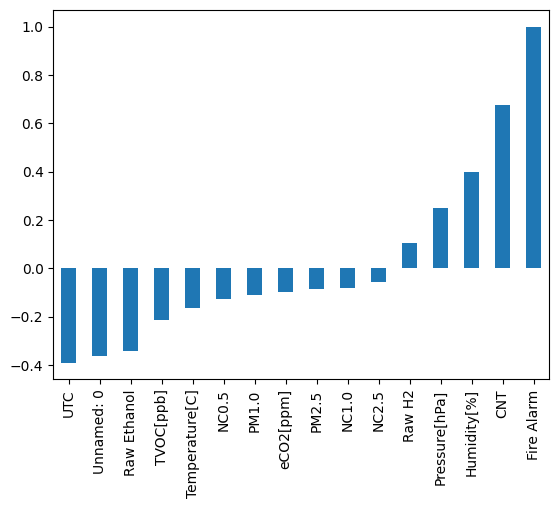

In [9]:
data.corr()["Fire Alarm"].sort_values().plot(kind='bar')

## deleting most uncorrelated data from DF

In [10]:
cols = ['Unnamed: 0',"PM2.5" , 'CNT' ,
             'UTC' , "Raw H2",
       'PM1.0' , 'NC0.5' ,'NC1.0' ,'NC2.5']

In [11]:
data2 = data.copy()
data2.drop(cols, axis=1, inplace=True)
data2

,Temperature[C],Humidity[%],TVOC[ppb],eCO2[ppm],Raw Ethanol,Pressure[hPa],Fire Alarm
0,20.000,57.36,0,400,18520,939.735,0
1,20.015,56.67,0,400,18651,939.744,0
2,20.029,55.96,0,400,18764,939.738,0
3,20.044,55.28,0,400,18849,939.736,0
4,20.059,54.69,0,400,18921,939.744,0
...,...,...,...,...,...,...,...
62625,18.438,15.79,625,400,20569,936.670,0
62626,18.653,15.87,612,400,20588,936.678,0
62627,18.867,15.84,627,400,20582,936.687,0
62628,19.083,16.04,638,400,20566,936.680,0


## outlier detection

for this purpose we must calculate upper and lower band of data.
<br>
first we should calculate Q1 , Q3 by quantile method which it sortes data itself.
<br>
second IQR = Q3-Q1
<br>
third upper bound = Q3+ 1.5 * IQR
<br>
lower band = Q1 - 1.5 * IQR

,0
Temperature[C],"Axes(0.125,0.798085;0.133621x0.0819149)"
Humidity[%],"Axes(0.285345,0.798085;0.133621x0.0819149)"
TVOC[ppb],"Axes(0.44569,0.798085;0.133621x0.0819149)"
eCO2[ppm],"Axes(0.606034,0.798085;0.133621x0.0819149)"
Raw Ethanol,"Axes(0.766379,0.798085;0.133621x0.0819149)"
Pressure[hPa],"Axes(0.125,0.699787;0.133621x0.0819149)"
Fire Alarm,"Axes(0.285345,0.699787;0.133621x0.0819149)"


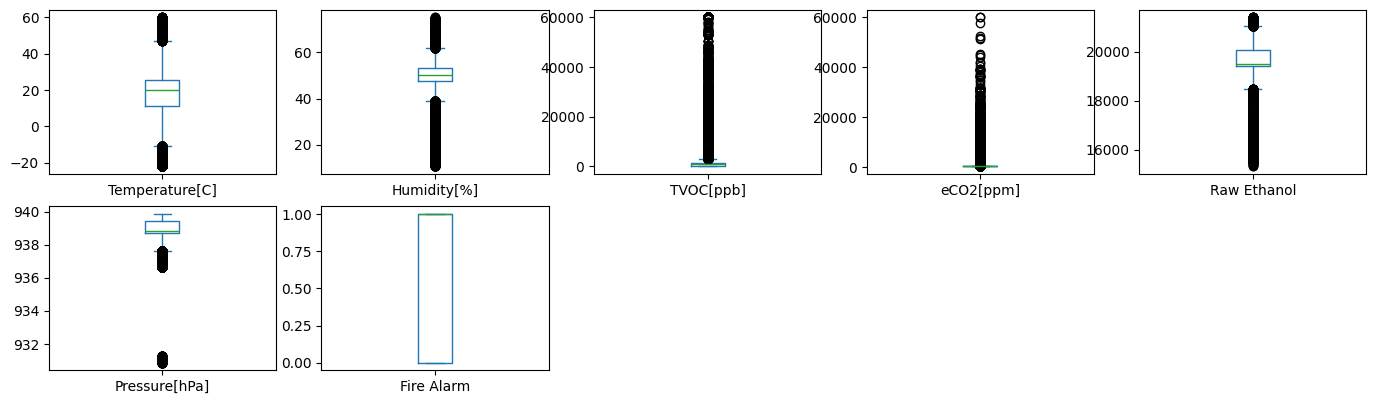

In [12]:
data2.plot(kind='box', subplots=True, layout=(8,5), figsize=(17,20))

In [13]:
def outlier_bands(df):

 Q1 = df.quantile(0.25)
 Q3 = df.quantile(0.75)

 IQR = Q3-Q1
 lower_band = Q1 - 1.5*IQR
 upper_band = Q3 + 1.5*IQR


 return lower_band,upper_band




In [14]:
low_band,up_band = outlier_bands(data2)

data_clean = data2.copy()
rows = range( len(data_clean) )

try:
  for row in rows:
    row_con = ( (data_clean.iloc[row]> up_band).any() ) and ( (data_clean.iloc[row]< low_band).any() )
    if(row_con) : data_clean.drop(row,axis = 0,inplace=True)
    else: continue

except:
  print("ran succesfull but beacuse of changing length we got error")

ran succesfull but beacuse of changing length we got error


In [15]:
data_clean.shape

(60184, 7)

In [16]:
data_clean = data_clean.reset_index(drop = True)


In [17]:
#data_clean.drop(["level_0","index"],axis=1,inplace=True)
data_clean

,Temperature[C],Humidity[%],TVOC[ppb],eCO2[ppm],Raw Ethanol,Pressure[hPa],Fire Alarm
0,20.000,57.36,0,400,18520,939.735,0
1,20.015,56.67,0,400,18651,939.744,0
2,20.029,55.96,0,400,18764,939.738,0
3,20.044,55.28,0,400,18849,939.736,0
4,20.059,54.69,0,400,18921,939.744,0
...,...,...,...,...,...,...,...
60179,18.438,15.79,625,400,20569,936.670,0
60180,18.653,15.87,612,400,20588,936.678,0
60181,18.867,15.84,627,400,20582,936.687,0
60182,19.083,16.04,638,400,20566,936.680,0


In [18]:
data_clean.describe().T

,count,mean,std,min,25%,50%,75%,max
Temperature[C],60184.0,15.758743,14.375699,-22.010,10.766,20.010,25.1585,59.930
Humidity[%],60184.0,48.791191,8.647876,10.740,47.650,50.370,53.2800,75.200
TVOC[ppb],60184.0,2001.133125,7957.849939,0.000,132.000,1017.000,1193.0000,60000.000
eCO2[ppm],60184.0,622.712216,1633.068235,400.000,400.000,400.000,437.0000,39185.000
Raw Ethanol,60184.0,19727.267031,594.772300,15317.000,19434.000,19485.000,20053.0000,21410.000
Pressure[hPa],60184.0,938.738460,1.116833,930.852,938.708,938.839,939.4750,939.861
Fire Alarm,60184.0,0.734614,0.441542,0.000,0.000,1.000,1.0000,1.000


In [19]:
y = data_clean["Fire Alarm"]

In [20]:
y

,Fire Alarm
0,0
1,0
2,0
3,0
4,0
...,...
60179,0
60180,0
60181,0
60182,0


In [21]:
y.value_counts()

,count
Fire Alarm,
1,44212
0,15972


In [ ]:
y = y.values
y

array([0, 0, 0, ..., 0, 0, 0])

In [22]:
data_clean.isnull().sum()

,0
Temperature[C],0
Humidity[%],0
TVOC[ppb],0
eCO2[ppm],0
Raw Ethanol,0
Pressure[hPa],0
Fire Alarm,0


In [23]:
x = data_clean[["Temperature[C]","Humidity[%]","TVOC[ppb]","eCO2[ppm]","Raw Ethanol","Pressure[hPa]"]].values

In [24]:
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [27]:
X_train, X_test, Y_train, Y_test = train_test_split(x,y,test_size=0.15, random_state=10)

In [28]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [29]:
x_ = (x- np.mean(x,axis=0)) / np.std(x,0)

In [30]:
#x_train = X_train.values
#y_train = Y_train
X_train

array([[-1.3406309 ,  0.38997124, -0.23717278, -0.13588632,  0.63260884,
         0.82624537],
       [ 0.7510805 ,  0.01004713, -0.09162874, -0.13588632, -0.52921381,
        -0.0413424 ],
       [ 0.59671348,  0.094862  , -0.24724504, -0.13588632, -0.0180791 ,
         0.94544906],
       ...,
       [ 0.40533733,  0.44225438, -0.24258662, -0.13588632,  0.69313795,
         0.80742373],
       [ 0.7510805 ,  0.07278689, -0.11769069, -0.1200495 , -0.45523379,
         0.07517248],
       [ 0.07914222,  0.01004713, -0.09288777, -0.12126771, -0.51744426,
        -0.02969091]])

### making nerual model generator

In [ ]:
data_clean.shape[1:]

(8,)

In [31]:

def model_gen ( n_HD_layer , n_neuron_list , input_shape = data_clean.shape[1:], ac_f = "sigmoid"):

  if not n_HD_layer == len(n_neuron_list) : print("number of hidden layers must be equal to len of list of number of neurons in each layer ")

  layer_list = []

  input_layer = tfk.layers.Input(input_shape,name = "input_layer")
  layer_list.append(input_layer)

  for i in range(n_HD_layer):

    hd_layer = tfk.layers.Dense(n_neuron_list[i], ac_f ,False,"glorot_normal",name = "hd_layer{}".format(i+1))(layer_list[-1])
    batch_layer = tfk.layers.BatchNormalization(name = "batch_layer{}".format(i+1))(hd_layer)
    drop_layer = tfk.layers.Dropout( 0.4 ,name = "drop_layer{}".format(i+1) )(batch_layer)

    layer_list.append(hd_layer)
    layer_list.append(batch_layer)
    layer_list.append(drop_layer)

  #drop_layer_final = tfk.layers.Dropout(0.4)(layer_list[-1])
  #layer_list.append(drop_layer_final)

  out_layer = tfk.layers.Dense(1,"sigmoid",False,name = "output_layer")(layer_list[-1])

  model = tfk.Model(inputs=input_layer , outputs =out_layer,name = "model01" )

  return model



In [37]:
model1 = model_gen(4 , [250,200,150,100] ,input_shape = X_train.shape[1:])
model1.summary()

Model: "model01"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 6)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hd_layer1 (Dense)               │ (None, 250)            │         1,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_layer1                    │ (None, 250)            │         1,000 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ drop_layer1 (Dropout)           │ (None, 250)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hd_layer2 (Dense)               │ (None, 200)            │        50,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_layer2                    │ (None, 200)            │           800 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ drop_layer2 (Dropout)           │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hd_layer3 (Dense)               │ (None, 150)            │        30,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_layer3                    │ (None, 150)            │           600 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ drop_layer3 (Dropout)           │ (None, 150)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hd_layer4 (Dense)               │ (None, 100)            │        15,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_layer4                    │ (None, 100)            │           400 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ drop_layer4 (Dropout)           │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 1)              │           100 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 99,400 (388.28 KB)

 Trainable params: 98,000 (382.81 KB)

 Non-trainable params: 1,400 (5.47 KB)

In [38]:
model1.compile(optimizer = "Adam", loss="binary_crossentropy",
               metrics = ["accuracy","binary_accuracy",
                          tfk.metrics.AUC(),tfk.metrics.Precision()],)

In [39]:
hist1 = model1.fit(x = X_train, y = Y_train , batch_size = 24 , epochs = 7, validation_split=0.15)

Epoch 1/7
1812/1812 ━━━━━━━━━━━━━━━━━━━━ 18s 6ms/step - accuracy: 0.8479 - auc_2: 0.9107 - binary_accuracy: 0.8479 - loss: 0.3456 - precision_2: 0.9102 - val_accuracy: 0.9268 - val_auc_2: 0.9902 - val_binary_accuracy: 0.9268 - val_loss: 0.1417 - val_precision_2: 0.9929
Epoch 2/7
1812/1812 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9257 - auc_2: 0.9781 - binary_accuracy: 0.9257 - loss: 0.1620 - precision_2: 0.9442 - val_accuracy: 0.9569 - val_auc_2: 0.9931 - val_binary_accuracy: 0.9569 - val_loss: 0.0906 - val_precision_2: 0.9770
Epoch 3/7
1812/1812 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.9418 - auc_2: 0.9859 - binary_accuracy: 0.9418 - loss: 0.1294 - precision_2: 0.9575 - val_accuracy: 0.9604 - val_auc_2: 0.9950 - val_binary_accuracy: 0.9604 - val_loss: 0.0865 - val_precision_2: 0.9540
Epoch 4/7
1812/1812 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.9494 - auc_2: 0.9884 - binary_accuracy: 0.9494 - loss: 0.1176 - precision_2: 0.9609 - val_accuracy: 0.9762 - val_auc_2: 0.996

In [45]:
model1.save("smoke_detection_iot.h5")

### model evaluation



In [46]:
eval = model1.evaluate(X_test, Y_test)

283/283 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9906 - auc_2: 0.9995 - binary_accuracy: 0.9906 - loss: 0.0301 - precision_2: 0.9888


In [47]:
print("final accuracy for test data is : " , eval[1])

final accuracy for test data is :  0.9888125658035278


###Classification Report

In [48]:
from sklearn.metrics import classification_report, confusion_matrix

y_hat = model1.predict(X_test)
y_hat_ = np.round(y_hat.T[0])
print(confusion_matrix( Y_test , y_hat_ )  )


283/283 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
[[2316   90]
 [  11 6611]]


In [49]:
print(classification_report(Y_test, y_hat_, target_names=["Alarm", "No Alarm"]))

              precision    recall  f1-score   support

       Alarm       1.00      0.96      0.98      2406
    No Alarm       0.99      1.00      0.99      6622

    accuracy                           0.99      9028
   macro avg       0.99      0.98      0.99      9028
weighted avg       0.99      0.99      0.99      9028



# Crossvalidation Task
Perform K-fold cross-validation on the preprocessed data (`x` and `y`) using the `model_gen` function. For each fold, scale the training and validation data, train a new model, and evaluate its performance. Finally, aggregate and present the average and standard deviation of the accuracy, AUC, precision, and loss across all folds.

## Prepare Data for K-fold

### Subtask:
Ensure the feature data (x) and target labels (y) are ready for K-fold cross-validation by converting them to NumPy arrays.


**Reasoning**:
The subtask requires converting the target labels `y` to a NumPy array and ensuring `x` is also a NumPy array. The existing code block `70euNKB_oOWE` performs the conversion of `y` to a NumPy array.



In [40]:
y = y.values
y

array([0, 0, 0, ..., 0, 0, 0])

## Initialize KFold

### Subtask:
Initialize a KFold object from `sklearn.model_selection` to define the cross-validation splitting strategy.


**Reasoning**:
To initialize the KFold object, I need to first import the KFold class from sklearn.model_selection and then instantiate it with the specified parameters (`n_splits=5`, `shuffle=True`, `random_state=42`).



In [41]:
from sklearn.model_selection import KFold

kf = KFold(n_splits=5, shuffle=True, random_state=42)
print("KFold object 'kf' initialized successfully.")

KFold object 'kf' initialized successfully.


## Implement K-fold Loop

### Subtask:
Iterate through each fold generated by KFold. In each iteration, perform the following: split the data into training and validation sets, apply StandardScaler independently, create and compile a new model, train the model, and evaluate its performance, storing the metrics.


**Reasoning**:
I need to implement the K-fold cross-validation loop as described in the instructions. This involves initializing lists for metrics, iterating through folds, splitting and scaling data, creating, compiling, and training a model for each fold, and finally evaluating and storing the metrics.



In [42]:
accuracy_scores = []
auc_scores = []
precision_scores = []
loss_scores = []

for fold, (train_index, val_index) in enumerate(kf.split(x)):
    print(f"\n--- Fold {fold+1}/{kf.n_splits} ---")

    # 3. Split the data into training and validation sets
    X_train_fold, X_val_fold = x[train_index], x[val_index]
    Y_train_fold, Y_val_fold = y[train_index], y[val_index]

    # 4 & 5. Instantiate StandardScaler and apply it
    sc = StandardScaler()
    X_train_fold = sc.fit_transform(X_train_fold)
    X_val_fold = sc.transform(X_val_fold)

    # 6. Create a new model instance for the current fold
    model_fold = model_gen(4, [250, 200, 150, 100], input_shape=X_train_fold.shape[1:])

    # 7. Compile the new model
    model_fold.compile(optimizer="Adam", loss="binary_crossentropy",
                       metrics=["accuracy", "binary_accuracy",
                                  tfk.metrics.AUC(), tfk.metrics.Precision()])

    # 8. Train the model
    history = model_fold.fit(x=X_train_fold, y=Y_train_fold, batch_size=24, epochs=7, verbose=0) # Set verbose to 0 to suppress output for each epoch

    # 9. Evaluate the trained model
    eval_metrics = model_fold.evaluate(X_val_fold, Y_val_fold, verbose=0)
    print(f"Fold {fold+1} Evaluation: Loss = {eval_metrics[0]:.4f}, Accuracy = {eval_metrics[1]:.4f}, AUC = {eval_metrics[3]:.4f}, Precision = {eval_metrics[4]:.4f}")

    # 10. Append the evaluated metrics to their respective lists
    loss_scores.append(eval_metrics[0])
    accuracy_scores.append(eval_metrics[1])
    auc_scores.append(eval_metrics[3]) # Assuming AUC is at index 3 based on compile metrics
    precision_scores.append(eval_metrics[4]) # Assuming Precision is at index 4 based on compile metrics

print("\nK-fold cross-validation complete. Metrics stored.")


--- Fold 1/5 ---
Fold 1 Evaluation: Loss = 0.0484, Accuracy = 0.9790, AUC = 0.9998, Precision = 0.9725

--- Fold 2/5 ---
Fold 2 Evaluation: Loss = 0.0431, Accuracy = 0.9817, AUC = 0.9990, Precision = 0.9792

--- Fold 3/5 ---
Fold 3 Evaluation: Loss = 0.0478, Accuracy = 0.9770, AUC = 0.9986, Precision = 0.9698

--- Fold 4/5 ---
Fold 4 Evaluation: Loss = 0.0428, Accuracy = 0.9814, AUC = 0.9996, Precision = 0.9756

--- Fold 5/5 ---
Fold 5 Evaluation: Loss = 0.0405, Accuracy = 0.9851, AUC = 0.9991, Precision = 0.9874

K-fold cross-validation complete. Metrics stored.


**Reasoning**:
Now that the K-fold cross-validation is complete and metrics for each fold are stored, the next step is to aggregate these results by calculating the mean and standard deviation for each metric (accuracy, AUC, precision, and loss).



In [44]:
print(f"\nAverage Accuracy: {np.mean(accuracy_scores):.4f} (+/- {np.std(accuracy_scores):.4f})")
print(f"Average AUC: {np.mean(auc_scores):.4f} (+/- {np.std(auc_scores):.4f})")
print(f"Average Precision: {np.mean(precision_scores):.4f} (+/- {np.std(precision_scores):.4f})")
print(f"Average Loss: {np.mean(loss_scores):.4f} (+/- {np.std(loss_scores):.4f})")


Average Accuracy: 0.9808 (+/- 0.0027)
Average AUC: 0.9992 (+/- 0.0004)
Average Precision: 0.9769 (+/- 0.0061)
Average Loss: 0.0445 (+/- 0.0031)


## Final Task

### Subtask:
Summarize the results of the K-fold cross-validation, including the average performance metrics and their variability.


## Summary:

### Q&A
The results of the K-fold cross-validation, including the average performance metrics and their variability, are as follows:
*   **Average Accuracy**: 0.9808 with a standard deviation of 0.0027
*   **Average AUC**: 0.9992 with a standard deviation of 0.0004
*   **Average Precision**: 0.9769 with a standard deviation of 0.0061
*   **Average Loss**: 0.0445 with a standard deviation of 0.0031

### Data Analysis Key Findings
*   The feature data (`x`) and target labels (`y`) were successfully prepared as NumPy arrays for K-fold cross-validation.
*   A KFold object was initialized with 5 splits, shuffling enabled, and a fixed random state for reproducibility.
*   For each of the 5 folds:
    *   Data was split into training and validation sets.
    *   `StandardScaler` was applied independently to scale the training and validation data.
    *   A new neural network model was generated, compiled with the Adam optimizer, binary cross-entropy loss, and metrics including accuracy, AUC, and precision.
    *   The model was trained for 7 epochs on the scaled training data.
    *   Performance metrics (loss, accuracy, AUC, precision) were evaluated on the scaled validation data and collected.
*   The aggregated results across all 5 folds demonstrate high average performance metrics: Average Accuracy of 0.9808, Average AUC of 0.9992, and Average Precision of 0.9769.
*   The variability (standard deviation) across folds for all metrics was very low, indicating the model's stability and robust performance across different data splits (e.g., Accuracy standard deviation of 0.0027, AUC standard deviation of 0.0004).

### Insights or Next Steps
*   The model exhibits excellent and stable performance across different subsets of the data, as evidenced by high average metrics and very low standard deviations in K-fold cross-validation. This suggests the model is robust and not significantly overfit to any particular data split.
*   Given the high performance metrics, further analysis could involve exploring the model's predictions on unseen data or investigating specific cases where the model makes errors to understand its limitations.
